In [28]:
from ultralytics import YOLO
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [29]:
def detect_tennisballs(model, general_path, show_images):
    folder_path = general_path + "/images"
    csv_path = general_path + "/distance_labels/annotations.csv"

    df = pd.read_csv(csv_path)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    results_dict = {}

    for image in image_files:

        image_path = os.path.join(folder_path, image)

        results = model(image_path)

        results_dict[image] = results

        annotated_frame = results[0].plot()

        if show_images:
            # Abstandswert aus CSV holen
            row = df[df['ImageName'] == image]
            if not row.empty:
                distance = row.iloc[0]['Distance']
                text = f"Abstand: {distance:.2f} m"

                # Text auf Bild zeichnen
                cv2.putText(annotated_frame, text, (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

            while True:

                cv2.imshow('Object Detection', annotated_frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            cv2.destroyAllWindows()
    return(results_dict)

## Auswertung der Bilder auf weißem Streifen

In [30]:
def auswertung_mit_statistik(results_dict, csv_path):
    statistik = []
    fehler_distanzen = []
    erkannt_distanzen = []
    keine_erkennung_distanzen = []
    df = pd.read_csv(csv_path)

    for image, results in results_dict.items():
        boxes = results[0].boxes

        detected_classes = boxes.cls.tolist() if boxes is not None else []
        sportsball_erkannt = 32 in detected_classes
        andere_objekte = [cls for cls in detected_classes if cls != 32]
        nichts_erkannt = len(detected_classes) == 0

        
        row = df[df['ImageName'] == image]
        distance = row.iloc[0]['Distance'] if not row.empty else None
        
        statistik.append({
            "Image": image,
            "Distance": distance,
            "Sportsball erkannt": sportsball_erkannt,
            "Andere Objekte erkannt": bool(andere_objekte),
            "Nichts erkannt": nichts_erkannt,
            "Boundingbox": boxes if sportsball_erkannt else None
        })

        if distance is not None:
            if sportsball_erkannt:
                erkannt_distanzen.append(distance)
            elif nichts_erkannt:
                keine_erkennung_distanzen.append(distance)
            else:
                fehler_distanzen.append(distance)

    df_stat = pd.DataFrame(statistik)

    # Statistik ausgeben
    print("\n--- Statistische Auswertung ---")
    print("Gesamtbilder:", len(df_stat))
    print("Sportsball erkannt:", df_stat['Sportsball erkannt'].sum())
    print("Fehlerkennungen (andere Objekte):", df_stat['Andere Objekte erkannt'].sum())
    print("Keine Erkennung:", df_stat['Nichts erkannt'].sum())

    # Optional: Histogramm der Distanzen
    plt.hist([erkannt_distanzen, fehler_distanzen, keine_erkennung_distanzen],
             bins=10,
             label=['Richtig erkannt', 'Falsch erkannt', 'Nicht erkannt'],
             color=['green', 'orange', 'red'],
             stacked=True)
    plt.xlabel('Distanz (m)')
    plt.ylabel('Anzahl Bilder')
    plt.legend()
    plt.title('Erkennung vs. Distanz')
    plt.show()

    return df_stat

In [31]:
model = YOLO('yolov8n.pt')

date = "2025-07-01_23-12-36_zweitausend"
general_path = "C:/Users/Lenovo/TennisCourt/TennisCourt/Assets/Screenshots/" + date
csv_path = general_path + "/distance_labels/annotations.csv"

filename = f'detection_results.pkl'
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        detections_results = pickle.load(f)
else:
    detections_results = detect_tennisballs(model, general_path, show_images=False)
    with open(filename, 'wb') as f:
        pickle.dump(detections_results, f)


--- Statistische Auswertung ---
Gesamtbilder: 2000
Sportsball erkannt: 1931
Fehlerkennungen (andere Objekte): 298
Keine Erkennung: 3


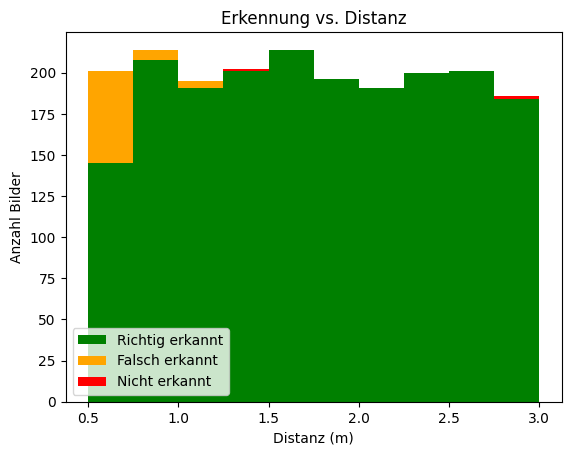

In [32]:
# Statistische auswertung
df_stat = auswertung_mit_statistik(detections_results, csv_path)

## Boundingbox Koordinaten rausziehen

In [33]:
df_stat.head()

,Image,Distance,Sportsball erkannt,Andere Objekte erkannt,Nichts erkannt,Boundingbox
0,2025-07-01_23-12-36_Screenshot_0.png,1.147651,True,False,False,(((ultralytics.engine.results.Boxes object wit...
1,2025-07-01_23-12-36_Screenshot_1.png,2.722906,True,False,False,(((ultralytics.engine.results.Boxes object wit...
2,2025-07-01_23-12-36_Screenshot_10.png,1.495645,True,False,False,(((ultralytics.engine.results.Boxes object wit...
3,2025-07-01_23-12-36_Screenshot_100.png,0.868309,True,True,False,(((ultralytics.engine.results.Boxes object wit...
4,2025-07-01_23-12-36_Screenshot_1000.png,2.678846,True,False,False,(((ultralytics.engine.results.Boxes object wit...


In [34]:
df_stat.shape    

(2000, 6)

Nur die Einträge, bei denen etwas erkannt wurde und eine korrekte Erkennung stattgefunden hat.

In [35]:
df_only_annotated = df_stat[df_stat["Nichts erkannt"] != True]
df_only_correctly_annotated = df_only_annotated[df_only_annotated["Andere Objekte erkannt"] != True]
print(df_only_correctly_annotated)

                                        Image  Distance  Sportsball erkannt  \
0        2025-07-01_23-12-36_Screenshot_0.png  1.147651                True   
1        2025-07-01_23-12-36_Screenshot_1.png  2.722906                True   
2       2025-07-01_23-12-36_Screenshot_10.png  1.495645                True   
4     2025-07-01_23-12-36_Screenshot_1000.png  2.678846                True   
6     2025-07-01_23-12-36_Screenshot_1002.png  2.802680                True   
...                                       ...       ...                 ...   
1993   2025-07-01_23-12-36_Screenshot_993.png  1.037910                True   
1994   2025-07-01_23-12-36_Screenshot_994.png  2.464071                True   
1996   2025-07-01_23-12-36_Screenshot_996.png  1.427935                True   
1998   2025-07-01_23-12-36_Screenshot_998.png  2.882388                True   
1999   2025-07-01_23-12-36_Screenshot_999.png  0.848105                True   

      Andere Objekte erkannt  Nichts erkannt  \
0  

In [36]:
df_only_correctly_annotated.shape

(1699, 6)

Nur die Bild Distanz und Boundingbox spalten, weil die Status ab hier irrelevant.

In [37]:
df_correctly_annotated_relevant_features = df_only_correctly_annotated[["Image", "Distance", "Boundingbox"]]
df_correctly_annotated_relevant_features.head()

,Image,Distance,Boundingbox
0,2025-07-01_23-12-36_Screenshot_0.png,1.147651,(((ultralytics.engine.results.Boxes object wit...
1,2025-07-01_23-12-36_Screenshot_1.png,2.722906,(((ultralytics.engine.results.Boxes object wit...
2,2025-07-01_23-12-36_Screenshot_10.png,1.495645,(((ultralytics.engine.results.Boxes object wit...
4,2025-07-01_23-12-36_Screenshot_1000.png,2.678846,(((ultralytics.engine.results.Boxes object wit...
6,2025-07-01_23-12-36_Screenshot_1002.png,2.802680,(((ultralytics.engine.results.Boxes object wit...


In [38]:
# Ersten Eintrag der Boundingbox aus der ersten Zeile Test
first_boundingbox = df_correctly_annotated_relevant_features.iloc[0]['Boundingbox']
print(first_boundingbox)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([32.])
conf: tensor([0.4636])
data: tensor([[305.4268, 291.9456, 334.6945, 320.6019,   0.4636,  32.0000]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[320.0606, 306.2737,  29.2677,  28.6562]])
xywhn: tensor([[0.5001, 0.4786, 0.0457, 0.0448]])
xyxy: tensor([[305.4268, 291.9456, 334.6945, 320.6019]])
xyxyn: tensor([[0.4772, 0.4562, 0.5230, 0.5009]])


xyxy Koordinaten aus den Boxes Objekten extrahieren.

In [39]:
def extract_xyxy_coordinates(boxes):
    if boxes is not None:
        return boxes.xyxy[0].tolist()
    else:
        return None
    
df_correctly_annotated_relevant_features['xyxy_coordinates'] = df_correctly_annotated_relevant_features['Boundingbox'].apply(extract_xyxy_coordinates)

print(df_correctly_annotated_relevant_features.head())

                                     Image  Distance  \
0     2025-07-01_23-12-36_Screenshot_0.png  1.147651   
1     2025-07-01_23-12-36_Screenshot_1.png  2.722906   
2    2025-07-01_23-12-36_Screenshot_10.png  1.495645   
4  2025-07-01_23-12-36_Screenshot_1000.png  2.678846   
6  2025-07-01_23-12-36_Screenshot_1002.png  2.802680   

                                         Boundingbox  \
0  (((ultralytics.engine.results.Boxes object wit...   
1  (((ultralytics.engine.results.Boxes object wit...   
2  (((ultralytics.engine.results.Boxes object wit...   
4  (((ultralytics.engine.results.Boxes object wit...   
6  (((ultralytics.engine.results.Boxes object wit...   

                                    xyxy_coordinates  
0  [305.4267883300781, 291.94561767578125, 334.69...  
1  [314.353515625, 259.4291687011719, 325.3599853...  
2  [309.5406494140625, 278.0224609375, 330.881347...  
4  [313.802001953125, 259.7805480957031, 325.4714...  
6  [314.064208984375, 258.95172119140625, 326.098..

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22116\4043030523.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correctly_annotated_relevant_features['xyxy_coordinates'] = df_correctly_annotated_relevant_features['Boundingbox'].apply(extract_xyxy_coordinates)


Koordinaten aus der Liste als eigenen Features ergänzen und dann nur Distanzen und Koordinatenfeatures behalten.

In [40]:
df_distance_xy = df_correctly_annotated_relevant_features[["Distance", "xyxy_coordinates"]]
#df_distance_xy[['x1', 'y1', 'x2', 'y2']] = pd.DataFrame(df_distance_xy['xyxy_coordinates'].tolist(), index=df_distance_xy.index)

df_distance_xy[['upperleft_x', 'upperleft_y', 'lowerright_x', 'lowerright_y']] = pd.DataFrame(df_distance_xy['xyxy_coordinates'].tolist(), index=df_distance_xy.index)
df_distance_xy = df_distance_xy[["Distance", "upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y"]]

df_distance_xy.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22116\3664957063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance_xy[['upperleft_x', 'upperleft_y', 'lowerright_x', 'lowerright_y']] = pd.DataFrame(df_distance_xy['xyxy_coordinates'].tolist(), index=df_distance_xy.index)


,Distance,upperleft_x,upperleft_y,lowerright_x,lowerright_y
0,1.147651,305.426788,291.945618,334.694489,320.601868
1,2.722906,314.353516,259.429169,325.359985,269.738068
2,1.495645,309.540649,278.022461,330.881348,300.116943
4,2.678846,313.802002,259.780548,325.471436,270.652802
6,2.802680,314.064209,258.951721,326.098328,269.164612


Isolating data and target

In [41]:
X = df_distance_xy[["upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y"]]
y = df_distance_xy[["Distance"]]

print(X.shape, y.shape)


(1699, 4) (1699, 1)


Splitting 80/20

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
X_train.shape, y_train.shape

((1359, 4), (1359, 1))

In [44]:
X_test.shape, y_test.shape

((340, 4), (340, 1))

## Predicting

In [45]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_prediction = model.predict(X_test)

## Evaluating predictions

In [46]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
mse = mean_squared_error(y_test, y_prediction)
print('Feature Names:', "upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y")
# Die Koeffizienten geben an, wie stark jede unabhängige Variable (Feature) die abhängige Variable (Zielvariable) beeinflusst. 
# Bei einem linearen Regressionsmodell beschreiben sie die lineare Beziehung zwischen den Prädiktoren und der Zielvariablen.
print('Coefficients:', model.coef_) 
# Gibt den Wert der Zielvariable an, wenn alle Features den Wert null haben.
print('Intercept:', model.intercept_) 
# Der Durchschnitt der quadrierten Abweichungen zwischen den vorhergesagten und tatsächlichen Werten
print('Mean squared error (MSE):', mse) 
# Umwandlung des MSE in RSME bringt den Wert auf die gleiche Skala wie die ursprünglichen Daten
print("Root mean squared error (RMSE):", np.sqrt(mse))  
print('Coefficient of determination (R2):', r2_score(y_test, y_prediction))
# Der Coefficient of determination gibt an, wie gut ein Modell die Streuung/Schwankung der Zielvariablen Y erklärt.
# "Erklärt" bedeutet, durch die Analyse der unabhängigen Variablen X zu bestimmen, warum und wie sich die Werte der (abhängigen) Zielvariablen ändern.
# Ein Wert von 1 bedeutet, das Modell erklärt die gesamte Streuung der Daten perfekt. Die Vorhersagen stimmen genau mit den tatsächlichen Werten überein.
# Ein Wert von 0 bedeutet, das Modell erklärt die Variation der Zielvariablen überhaupt nicht besser als der Durchschnitt. Die Vorhersagen sind also nicht besser als der Mittelwert der Zielvariablen.
# Ein Wert von < 0 bedeutet, das Modell ist schlechter als eine einfache Vorhersage mit dem Mittelwert (z.B. bei schlechten Modellen oder bei Overfitting).

Feature Names: upperleft_x upperleft_y lowerright_x lowerright_y
Coefficients: [[ -0.0018228    0.077174    -0.15663   -0.045406]]
Intercept: [     46.375]
Mean squared error (MSE): 0.07918799899572626
Root mean squared error (RMSE): 0.2814036229257297
Coefficient of determination (R2): 0.8274053236417698


Der Meansquared error ist sehr gering, je geringer desto besser.\
Im Durchschnitt weichen die Vorhersagen nur um 0.29 m (RSME) vom tatsächlichen Wert ab.\
Das Modell erklärt die Streuung der Daten relativ zuverlässig (R2).

In [47]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error

# mlmodel: das machinelearning model, das man vorher initialisiert hat, dessen learning curve man plotten will
# X_input: der Datensatz an unabhängigen parameter/features, die genutzt werden, um die abhängigen Variablen/Target variables zu bestimmen
# y_input: der Datensatz an abhängigen Variablen, die predicted werden sollen
def plot_learningCurveDisplay(mlmodel, X_input, y_input):
    
    # Erzeuge einen plot, um die Learning curve visuell darzustellen.    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    
    # Die learning curve function bildet nicht nur die Lernkurve des angegebenen Models ab.
    # Bevor sie das tut, splittet sie die Daten mehrmals in Trainings und Test sets verschiedener größen.
    # Dann trainiert sie das Model mit den jeweiligen Trainingsdatensätzen.
    # Und im Anschluss lässt sie das Modell die abhängigen Variablen y für jeden Testdatensatz bestimmen.
    # Dann vergleicht sie, wie die predictions sich zu den tatsächlichen Target values verhalten und plottet den MSE für jeden Datensatzsplit.
    common_params = {
        "X": X_input, # X Datensatz
        "y": y_input, # y datensatz
        "train_sizes": np.linspace(0.1, 1.0, 10),   # Erstelle 10 verschiedenen Trainingsdatensätze, von 10% bis 100% Datenmenge
        # Shufflesplit erstellt für jeden der Trainingsdatensätze Cross validation Datensätze, in denen sich die Verteilung der Daten immer unterscheidet
        # n_splits bestimmt den amount der Cross validations; test_size legt fest, dass für jeden Trainingsdatensatz 10% der Daten als Testdatensatz verwendet werden sollen.
        # random_state steuert die zufälligkeit des Datensplittings. Wenn random_state nicht gesetzt ist, werden beim Aufruf der shuffle split function für dieselben
        # Trainingsdaten mit den gleichen Parametern, die Daten immer anders aufgeteilt. 
        # Wenn ich random_state mit einem Integer versehe, werden für dieselben Trainingsdaten mit den gleichen Parametern die Daten immer gleich aufgeteilt.
        # Man kann sich das so vorstellen wie, wenn ich die Formel y=a*x+b habe, und randomstate ist nicht gesetzt, wird für x immer eine zufällige Zahl eingesetzt.
        # Das heißt, der Outcome ist nicht vorhersagbar.
        # Wenn ich jedoch random_state = 42 setze, wird für x immer 42 eingesetzt. Somit ist der Outcome vorhersagbar/reproduzierbar.
        "cv": ShuffleSplit(n_splits=100, test_size=0.2, random_state=2), 
        "score_type": "both", # bedeutet, dass die Lernkurve für beide Scores, den auf den Trainingsdaten und den auf den Testdaten, gleichzeitig dargestellt wird.
        "n_jobs": 4, # gibt an, wie viele Prozessor-Kerne (Threads) parallel verwendet werden sollen, um Berechnungen durchzuführen.
        "line_kw": {"marker": "o"}, # Darstellung der Durchschnittswerte als Kreis
        "std_display_style": "fill_between",    # Füllt den Bereich zwischen der oberen und unteren Grenze der Standardabweichung farblich
        "score_name": "MSE",    # Label des scores/Y-Achse
    }
    
    # Erstelle eine lernkurve auf Basis des übergebenen mlmodels und der festgelegten common_params.
    # Dann stelle das ganze auf der Achse ax dar.
    # Nutze für die Darstellung den mean_squared_error (scoring)
    LearningCurveDisplay.from_estimator(mlmodel, **common_params, ax=ax, scoring=make_scorer(mean_squared_error))
    
    # Label Parameter für den Plot
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(f"Learning Curve for {mlmodel.__class__.__name__}")
    
    # Den plot darstellen
    plt.show()

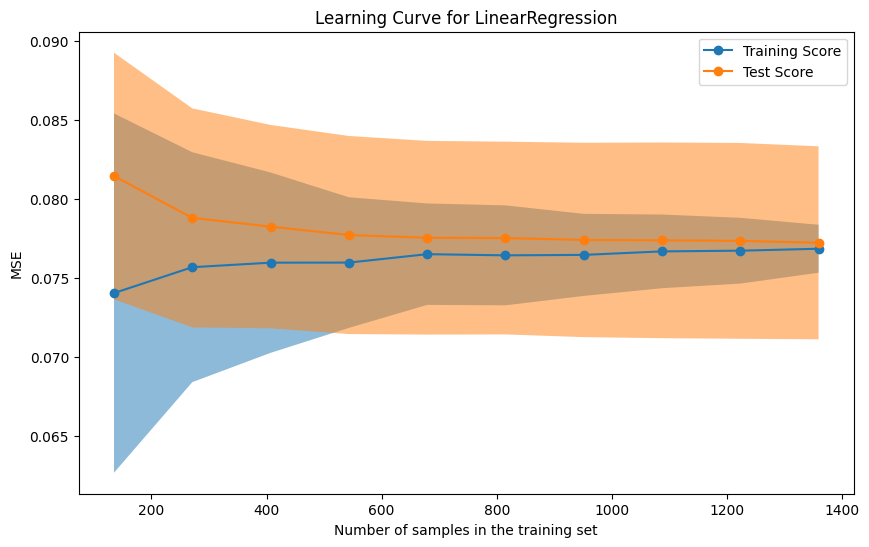

In [48]:
plot_learningCurveDisplay(model, X, y)

Der MSE ist bereits von Anfang an sehr gering, höchstwahrscheinlich weil es sich bei disem Problem um ein Problem mit sehr linearer Bezeihung handelt, dass einfach durch lineare Regression gelöst werden kann.
Bounding Box Größe zu Entfernung.

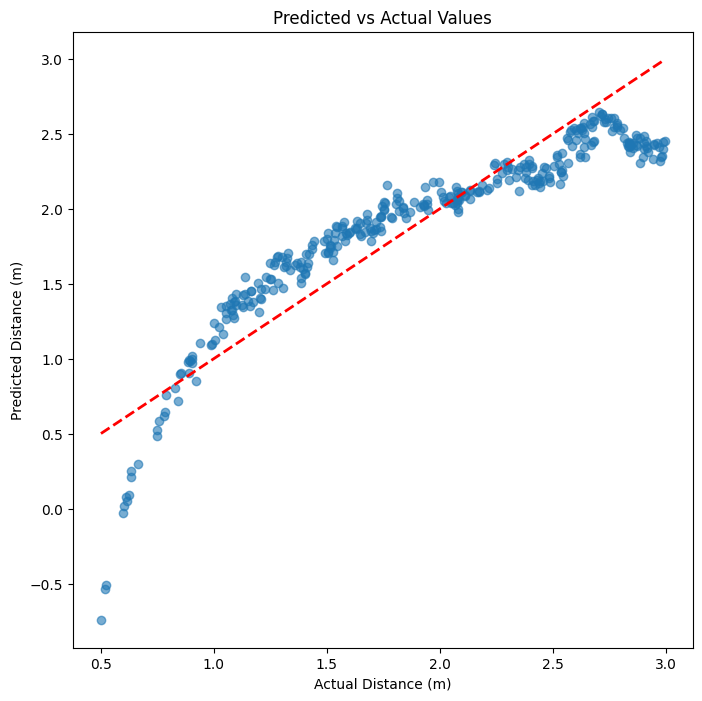

In [58]:
def plot_predicted_vs_actual(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Distance (m)')
    plt.ylabel('Predicted Distance (m)')
    plt.title('Predicted vs Actual Values')
    plt.show()

plot_predicted_vs_actual(model, X_test, y_test)

In [50]:
def predict_distance_from_image(yolo_model, regression_model, image_path):
    results = yolo_model(image_path)
    boxes = results[0].boxes
    
    if boxes is None or len(boxes) == 0:
        return "Kein Ball erkannt"
    
    detected_classes = boxes.cls.tolist()
    sportsball_indices = [i for i, cls in enumerate(detected_classes) if cls == 32]
    
    if not sportsball_indices:
        return "Kein Sportsball erkannt"
    
    predictions = []
    
    for idx in sportsball_indices:
        bbox = boxes.xyxy[idx].tolist()
        upperleft_x, upperleft_y, lowerright_x, lowerright_y = bbox
        features = [[upperleft_x, upperleft_y, lowerright_x, lowerright_y]]
        predicted_distance = regression_model.predict(features)[0][0]
        
        predictions.append({
            'bbox': bbox,
            'predicted_distance': predicted_distance
        })
    
    return predictions

In [51]:
def visualize_prediction(yolo_model, regression_model, image_path, annotations_path):
    import cv2
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    
    predictions = predict_distance_from_image(yolo_model, regression_model, image_path)
    
    if isinstance(predictions, str):
        print(predictions)
        return
    
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path)
    print("Bildname:", image_name)

    df = pd.read_csv(annotations_path)
    print("DF: ", df)
    row = df[df['ImageName'] == image_name]
    print("Row: ", row)
    actual_distance = row.iloc[0]['Distance'] if not row.empty else None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image_rgb)
    
    for i, pred in enumerate(predictions):
        bbox = pred['bbox']
        distance = pred['predicted_distance']
        
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        rect = patches.Rectangle((x1, y1), width, height, 
                               linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        label = f"Ball {i+1}:\nPredcited: {distance:.2f}m\nActual: {actual_distance}m"
        ax.text(x1, y1-10, label, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7),
               fontsize=10, color='black', weight='bold')
    
    ax.set_title(f"Tennisball Distanzschätzung\nGefunden: {len(predictions)} Ball(s)", 
                fontsize=14, weight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predictions


image 1/1 C:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\data\0_test_image\2025-07-05_15-54-29_Screenshot_0.png: 640x640 1 sports ball, 75.0ms
Speed: 2.4ms preprocess, 75.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Vorhersagen: [{'bbox': [313.44561767578125, 260.1419982910156, 326.01190185546875, 272.2564392089844], 'predicted_distance': np.float64(2.4538355698531547)}]

image 1/1 C:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\data\0_test_image\2025-07-05_15-54-29_Screenshot_0.png: 640x640 1 sports ball, 70.3ms
Speed: 2.3ms preprocess, 70.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Bildname: 2025-07-05_15-54-29_Screenshot_0.png
DF:                                ImageName  Distance
0  2025-07-05_15-54-29_Screenshot_0.png     2.578
Row:                                ImageName  Distance
0  2025-07-05_15-54-29_Screenshot_0.png     2.578


c:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


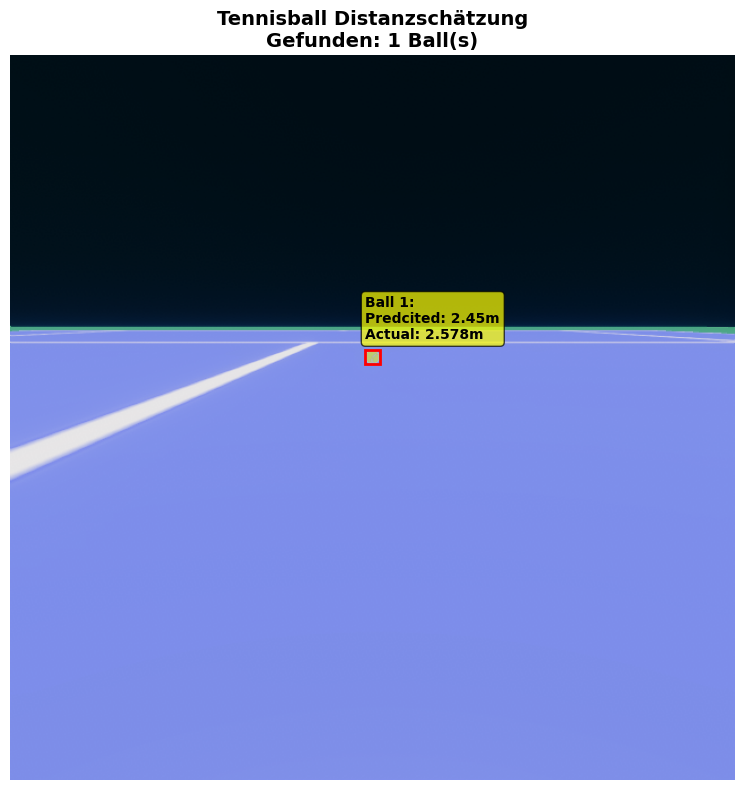

[{'bbox': [313.44561767578125,
   260.1419982910156,
   326.01190185546875,
   272.2564392089844],
  'predicted_distance': np.float64(2.4538355698531547)}]

In [52]:
yolo_model = YOLO('yolov8n.pt')  # YOLO Model
distance_model = model  

test_image_path = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/0_test_image/2025-07-05_15-54-29_Screenshot_0.png"
test_csv_path = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/0_test_image/annotations.csv"

predictions = predict_distance_from_image(yolo_model, distance_model, test_image_path)
print("Vorhersagen:", predictions)

visualize_prediction(yolo_model, distance_model, test_image_path, test_csv_path)

In [53]:
eins = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/1_test_2/2025-07-05_16-36-34_Screenshot_0.png"
zwei = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/1_test_2/annotations.csv"

predictions = predict_distance_from_image(yolo_model, distance_model, eins)
print("Vorhersagen:", predictions)

visualize_prediction(yolo_model, distance_model, eins, zwei)


image 1/1 C:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\data\1_test_2\2025-07-05_16-36-34_Screenshot_0.png: 640x640 1 frisbee, 68.9ms
Speed: 2.2ms preprocess, 68.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Vorhersagen: Kein Sportsball erkannt

image 1/1 C:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\data\1_test_2\2025-07-05_16-36-34_Screenshot_0.png: 640x640 1 frisbee, 70.0ms
Speed: 2.1ms preprocess, 70.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Kein Sportsball erkannt


data\1_test_2\annotations.csv

# xyxy Format:
Format: [x1, y1, x2, y2]
Bedeutung: Koordinaten der beiden gegenüberliegenden Ecken
x1, y1 = Obere linke Ecke
x2, y2 = Untere rechte Ecke
Beispiel: [305, 292, 335, 321]

# xywh Format:
Format: [center_x, center_y, width, height]
Bedeutung: Zentrum der Box + Dimensionen
center_x, center_y = Mittelpunkt der Bounding Box
width, height = Breite und Höhe der Box
Beispiel: [320, 306, 29, 29]